<a href="https://colab.research.google.com/github/MichalKucko/MLK/blob/master/clash_royale_challenge_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load necessary packages

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from google.colab import files

%matplotlib inline

In [33]:
uploaded = files.upload()

Saving nuSVM_50_no_weights_best.txt to nuSVM_50_no_weights_best.txt


In [5]:
# Read data and present

train = pd.read_csv('trainingData.csv')
valid = pd.read_csv('validationData.csv')
train.head()

,deck,nofGames,nOfPlayers,winRate
0,archers;arrows;baby-dragon;balloon;bats;fireba...,44,2,0.58511
1,archers;arrows;baby-dragon;balloon;bomber;free...,143,3,0.53767
2,archers;arrows;baby-dragon;balloon;bomber;gian...,61,3,0.34375
3,archers;arrows;baby-dragon;balloon;cannon;free...,162,1,0.49394
4,archers;arrows;baby-dragon;balloon;electro-wiz...,57,1,0.55833


In [0]:
valid.head()

,deck,nofGames,nOfPlayers,winRate
0,archers;arrows;baby-dragon;bandit;elixir-colle...,130,32,0.48496
1,archers;arrows;baby-dragon;elixir-collector;go...,495,75,0.47289
2,archers;arrows;baby-dragon;golem;lightning;meg...,271,25,0.52372
3,archers;arrows;baby-dragon;golem;lightning;meg...,125,20,0.58594
4,archers;arrows;balloon;barbarians;fireball;gia...,130,23,0.50000


In [0]:
# Helper functions to preprocess data to bag-of-cards format

def unnest(df, col):
    unnested = (df.apply(lambda x: pd.Series(x[col]), axis=1)
                .stack()
                .reset_index(level=1, drop=True))
    unnested.name = col
    return df.drop(col, axis=1).join(unnested)

def to_bag_of_cards(df):
    df['ind'] = np.arange(df.shape[0]) + 1
    df_orig = df.copy()
    df['deck'] = df['deck'].apply(lambda d: d.split(';'))
    df = unnest(df, 'deck')
    df['value'] = 1
    df_bag = df.pivot(index='ind', columns='deck', values='value')
    df_bag[df_bag.isna()] = 0
    df_bag = df_bag.astype('int')
    return pd.concat([df_orig.set_index('ind'), df_bag], axis=1)

In [7]:
train = to_bag_of_cards(train)
valid = to_bag_of_cards(valid)
train.head()

,deck,nofGames,nOfPlayers,winRate,archers,arrows,baby-dragon,balloon,bandit,barbarian-barrel,barbarian-hut,barbarians,bats,battle-ram,bomb-tower,bomber,bowler,cannon,cannon-cart,clone,dark-prince,dart-goblin,electro-dragon,electro-wizard,elite-barbarians,elixir-collector,executioner,fire-spirits,fireball,flying-machine,freeze,furnace,giant,giant-skeleton,giant-snowball,goblin-barrel,goblin-gang,goblin-giant,goblin-hut,goblins,...,lumberjack,magic-archer,mega-knight,mega-minion,miner,mini-pekka,minion-horde,minions,mirror,mortar,musketeer,night-witch,pekka,poison,prince,princess,rage,ram-rider,rascals,rocket,royal-ghost,royal-giant,royal-hogs,royal-recruits,skeleton-army,skeleton-barrel,skeletons,sparky,spear-goblins,tesla,the-log,three-musketeers,tombstone,tornado,valkyrie,witch,wizard,x-bow,zap,zappies
ind,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,archers;arrows;baby-dragon;balloon;bats;fireba...,44,2,0.58511,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,archers;arrows;baby-dragon;balloon;bomber;free...,143,3,0.53767,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,archers;arrows;baby-dragon;balloon;bomber;gian...,61,3,0.34375,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,archers;arrows;baby-dragon;balloon;cannon;free...,162,1,0.49394,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,archers;arrows;baby-dragon;balloon;electro-wiz...,57,1,0.55833,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [0]:
valid.head()

,deck,nofGames,nOfPlayers,winRate,archers,arrows,baby-dragon,balloon,bandit,barbarian-barrel,...,the-log,three-musketeers,tombstone,tornado,valkyrie,witch,wizard,x-bow,zap,zappies
ind,,,,,,,,,,,,,,,,,,,,,
1,archers;arrows;baby-dragon;bandit;elixir-colle...,130,32,0.48496,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,archers;arrows;baby-dragon;elixir-collector;go...,495,75,0.47289,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,archers;arrows;baby-dragon;golem;lightning;meg...,271,25,0.52372,1,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,archers;arrows;baby-dragon;golem;lightning;meg...,125,20,0.58594,1,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,archers;arrows;balloon;barbarians;fireball;gia...,130,23,0.50000,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [0]:
# Sort data by number of games played

train = train.sort_values('nofGames', ascending=False)
valid = valid.sort_values('nofGames', ascending=False)

In [0]:
# Specify example model fitting function and R squared metric

from sklearn.svm import SVR, NuSVR

def R2(x, y):
    return 1 - np.sum(np.square(x - y)) / np.sum(np.square(y - np.mean(y)))

def fit_svm(data):
    svr = SVR(kernel='rbf', gamma=1.0/90, C=1.0, epsilon=0.02, shrinking=False)
    svr.fit(data.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1), data['winRate'])
    return svr

sizes = (np.arange(10) + 6) * 100

In [0]:
# Fit and predict on models of various training sizes

fit_list = list(map(lambda size: fit_svm(train.iloc[:size]), sizes))
pred_list = list(map(lambda fit: fit.predict(valid.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1)),
                     fit_list))

In [0]:
from sklearn.model_selection import GridSearchCV

score = train['nofGames']
train_sel_idx = np.where(score > np.percentile(score, 50))
train_sel = train.iloc[train_sel_idx]

# ustalenie wag przykładów
p1 = np.percentile(score, 50)
med = np.median(score)
p2 = np.percentile(score, 80)
weights = np.array([0.2 if nof < p1 else 0.2+0.8*(nof-p1)/(p2-p1) if nof < p2 else 1 for nof in score])
#weights = np.array([1 if nof < p1 else 1-(nof-p1)/(p2-p1)*0.8 if nof < p2 else 0.2 for nof in score])
print('weights mean:', np.mean(weights[train_sel_idx]))

r2s = []
decks = []
# parametry do sprawdzenia przez CV
param_grid = [
  {'C': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0], 'gamma': [0.1/90, 0.5/90, 1.0/90, 2.0/90, 5.0/90, 10.0/90]},
]
results = []
epsilons = []
valid_decks = valid.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1)
  
for s in sizes:
  print('size:', s)
    
  # nuSVM  
  nu = s / train_sel.shape[0]
  nuSVM = NuSVR(kernel='rbf', gamma=10.0/90, C=0.1, nu=nu, shrinking=False)
  nuSVM.fit(train_sel.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1), train_sel['winRate'])
  #nuSVM.fit(train_sel.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1), train_sel['winRate'], sample_weight=weights[train_sel_idx])
  preds = nuSVM.predict(valid_decks)
  print('nu:', nu, 'R2:', R2(preds, valid['winRate']), 'SV:', len(nuSVM.support_))
  
  # ustalenie epsilona
  train_sv = train_sel.iloc[nuSVM.support_]
  preds_sv = nuSVM.predict(nuSVM.support_vectors_)
  eps = np.min(np.abs(preds_sv-train_sv['winRate'])) - 0.0001
  print('eps:', eps)
  
  # wzięcie wektorów nośnych o najwyższych współczynnikach 
  svs = train_sel_idx[0][nuSVM.support_[np.argsort(np.abs(nuSVM.dual_coef_))[0,::-1]][:s]]
  #svs = train_sel_idx[0][nuSVM.support_[np.argsort(train_sv['nofGames'])[::-1]][:s]]
  train_fin = train.iloc[svs]
  
  # wagi wektorów nośnych
  #weights2 = weights[svs]
  #param_grid[0]['C'].append(np.mean(weights2))
  #print('weights2 mean:', np.mean(weights2))
  
  # grid search na trainie 
  SVM = SVR(kernel='rbf', epsilon=eps, C = 1.0, gamma = 1.0/90, shrinking=False) 
  #grid = GridSearchCV(cv=5, estimator=SVM, param_grid=param_grid, n_jobs=-1, iid=True, verbose=0)
  #grid.fit(train_fin.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1), train_fin['winRate'])
  #grid.fit(train_fin.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1), train_fin['winRate'], sample_weight=weights2)
  #SVM.C = grid.best_params_['C']
  #SVM.gamma = grid.best_params_['gamma']
  #print(grid.best_params_)
  
  # grid search na walidacyjnym
  bestR2 = -1000
  bestC = 0
  bestGamma = 0
  train_fin_decks = train_fin.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1)
  for cost in [0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0]:
    SVM.C = cost
    for gamma in [0.1/90, 0.5/90, 1.0/90, 2.0/90, 5.0/90, 10.0/90, 20.0/90, 50.0/90]:     
      SVM.gamma = gamma
      SVM.fit(train_fin_decks, train_fin['winRate'])
      preds = SVM.predict(valid_decks)
      r2 = R2(preds, valid['winRate'])
      if r2 > bestR2:
        bestR2 = r2
        bestC = cost
        bestGamma = gamma
  
  print('best C:', bestC, 'best gamma:', bestGamma)
  SVM.C = bestC
  SVM.gamma = bestGamma
  SVM.fit(train_fin_decks, train_fin['winRate'])
  preds_fin = SVM.predict(valid_decks)
  print('fin R2:', R2(preds_fin, valid['winRate']), 'fin SV:', len(SVM.support_))
  r2s.append(R2(preds_fin, valid['winRate']))
  decks.append(svs)
  ind_text = ','.join(map(str, svs+1))
  text = ';'.join([str(eps), str(bestC), str(bestGamma), ind_text])
  results.append(text)
  epsilons.append(eps)
  
  #param_grid[0]['C'].remove(np.mean(weights2))

In [0]:
train_sv = train.iloc[nuSVM.support_]
preds_sv = nuSVM.predict(nuSVM.support_vectors_)
eps = np.min(np.abs(preds_sv-train_sv['winRate'])) + 0.001

r2s = []
decks = []

for s in sizes:
  print('size:', s) 
  
  SVM = SVR(kernel='rbf', epsilon=eps, C=1.0, gamma=1.0/90, shrinking=False)
  #svs = nuSVM.support_[np.argsort(np.abs(nuSVM.dual_coef_))[0,::-1]][:s]
  svs = nuSVM.support_[np.argsort(train_sv['nofGames'])[::-1]][:s]
  print(svs.shape)
  train_fin = train.iloc[svs]
  SVM.fit(train_fin.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1), train_fin['winRate'])
  preds_fin = SVM.predict(valid.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1))
  print('fin R2:', R2(preds_fin, valid['winRate']), 'fin SV:', len(SVM.support_))
  r2s.append(R2(preds_fin, valid['winRate']))
  decks.append(svs)
  
  #if s >= 1100: break

In [0]:
#weights = np.minimum(1, np.percentile(train['nOfPlayers'], 30) / train['nOfPlayers'])
#weights = np.minimum(1, train['nOfPlayers'] / np.percentile(train['nOfPlayers'], 70))
score = train['nofGames']
p1 = np.percentile(score, 50)
med = np.median(score)
p2 = np.percentile(score, 90)
#weights = np.array([0.25 if nof < p1 else 0.5 if nof < med else 0.75 if nof < p2 else 1 for nof in score])
weights = np.array([0.2 if nof < p1 else 0.2+0.8*(nof-p1)/(p2-p1) if nof < p2 else 1 for nof in score])
#weights = np.array([1 if nof < p1 else 1-(nof-p1)/(p2-p1)*0.7 if nof < p2 else 0.3 for nof in score])
np.mean(weights)
#weights

0.38782103414634156

In [0]:
score = train['nofGames']

train_sel = train[score > np.percentile(score, 50)]
weights = weights[score > np.percentile(score, 50)]

nuSVM = NuSVR(kernel='rbf', gamma=1.0/90, C=1.0, nu=600/train_sel.shape[0], shrinking=False)
nuSVM.fit(train_sel.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1), train_sel['winRate'], sample_weight=weights)
preds = nuSVM.predict(valid.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1))
print(R2(preds, valid['winRate']))
print(len(nuSVM.support_))

svs = nuSVM.support_[np.argsort(np.abs(nuSVM.dual_coef_))[0,::-1]][:600]
train_fin = train_sel.iloc[svs]
#weights2 = weights[svs]
#print(np.mean(weights2), np.min(weights2), np.max(weights2))

train_sv = train_sel.iloc[nuSVM.support_]
preds_sv = nuSVM.predict(nuSVM.support_vectors_)
eps = np.min(np.abs(preds_sv-train_sv['winRate'])) - 0.0001

nuSVM2 = SVR(kernel='rbf', gamma=1.0/90, C=1.0, epsilon=eps, shrinking=False)
nuSVM2.fit(train_fin.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1), train_fin['winRate'])
preds2 = nuSVM2.predict(valid.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1))
print('fin R2:', R2(preds2, valid['winRate']), 'fin SV:', len(nuSVM2.support_))

0.16924324474512786
922
fin R2: 0.1666064995539559 fin SV: 544


In [0]:
svs = SVM.support_[np.argsort(np.abs(SVM.dual_coef_))[0,::-1]][:600]
print(svs)
svs+=1
svs

In [0]:
train2 = train.iloc[nuSVM.support_]
train2rest = train[~train.isin(train2).all(axis=1)]
preds_sv = nuSVM.predict(nuSVM.support_vectors_)
preds_rest = nuSVM.predict(train2rest.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1))
print(np.min(np.abs(preds_sv-train2['winRate'])))
print(np.max(np.abs(preds_rest-train2rest['winRate'])))

0.18214939603225283
0.1829810953645662


In [0]:
# Calculate R squared scores

r2 = list(map(lambda p: R2(p, valid['winRate']), pred_list))
r2

[0.10373109936713065,
 0.08396547920847852,
 0.06980116796523095,
 0.0668174361392635,
 0.07765615473273124,
 0.09099199390164214,
 0.08381425193451242,
 0.09815506204837154,
 0.10822249183772714,
 0.12209963924519163]

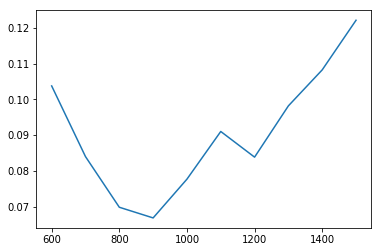

In [0]:
_ = plt.plot(sizes, r2)

In [31]:
np.mean(r2s)

0.2444155220458327

In [0]:
# Save hyperparameteres and selected indices in submission format

with open('example_sub_python.txt', 'w') as f:
    for size in sizes:
        ind_text = ','.join(list(map(str, train.index.values[:size])))
        text = ';'.join(['0.02', '1.0', str(1.0 / 90), ind_text])
        f.write(text + '\n')
files.download('example_sub_python.txt')

In [0]:
with open('nuSVM_50_no_weights_best.txt', 'w') as f:
  for res in results:
    f.write(res + '\n')
files.download('nuSVM_50_no_weights_best.txt')

In [34]:
# sprawdzenie, czy dane z pliku dają dobre wyniki
with open('nuSVM_50_no_weights_best.txt', 'r') as f:
  lines = f.readlines()

for line in lines:
  data = line.split(';')
  SVM = SVR(kernel='rbf', epsilon=float(data[0]), C = float(data[1]), gamma = float(data[2]), shrinking=False)
  train_set = train.iloc[[int(idx)-1 for idx in data[-1].split(',')]]
  SVM.fit(train_set.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1), train_set['winRate'])
  preds = SVM.predict(valid.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1))
  print('R2:', R2(preds, valid['winRate']), 'SV:', len(SVM.support_))

R2: 0.22628731663683355 SV: 600
R2: 0.23229101588650702 SV: 699
R2: 0.23946813027526104 SV: 798
R2: 0.24804856351009374 SV: 898
R2: 0.24741949229557558 SV: 998
R2: 0.2473995434311762 SV: 1100
R2: 0.24893867910439804 SV: 1200
R2: 0.24830393638845938 SV: 1300
R2: 0.2525457887777156 SV: 1399
R2: 0.2534527541523067 SV: 1500


In [0]:
# dodanie 1 do indeksów w pliku
with open('nuSVM_50_no_weights.txt', 'r') as f:
  lines = f.readlines()

with open('nuSVM_50_no_weights2.txt', 'w') as f:
  for line in lines:
    data = line.split(';')
    data[-1] = ','.join([str(int(idx)+1) for idx in data[-1].split(',')])
    f.write(';'.join(data)+'\n')
files.download('nuSVM_50_no_weights2.txt')